### mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

Mounted at /content/drive


### load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.chdir(current_path)


interval = '30m'
interval = '1m'
date_path = './candlestick_concated/%s/2021-04-27/' % interval
date_path = './candlestick_concated/%s/2021-05-17/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-05-17 BTCUSDT.xlsx', '2021-05-17 ETHUSDT.xlsx', '2021-05-17 BCHUSDT.xlsx', '2021-05-17 XRPUSDT.xlsx', '2021-05-17 EOSUSDT.xlsx', '2021-05-17 LTCUSDT.xlsx', '2021-05-17 ETCUSDT.xlsx', '2021-05-17 LINKUSDT.xlsx', '2021-05-17 XLMUSDT.xlsx', '2021-05-17 ADAUSDT.xlsx', '2021-05-17 XMRUSDT.xlsx', '2021-05-17 SXPUSDT.xlsx', '2021-05-17 KAVAUSDT.xlsx', '2021-05-17 BANDUSDT.xlsx', '2021-05-17 DASHUSDT.xlsx', '2021-05-17 ZECUSDT.xlsx', '2021-05-17 XTZUSDT.xlsx', '2021-05-17 BNBUSDT.xlsx', '2021-05-17 ATOMUSDT.xlsx', '2021-05-17 ONTUSDT.xlsx', '2021-05-17 IOTAUSDT.xlsx', '2021-05-17 BATUSDT.xlsx', '2021-05-17 NEOUSDT.xlsx', '2021-05-17 QTUMUSDT.xlsx', '2021-05-17 WAVESUSDT.xlsx', '2021-05-17 MKRUSDT.xlsx', '2021-05-17 SNXUSDT.xlsx', '2021-05-17 DOTUSDT.xlsx', '2021-05-17 THETAUSDT.xlsx', '2021-05-17 ALGOUSDT.xlsx', '2021-05-17 KNCUSDT.xlsx', '2021-05-17 ZRXUSDT.xlsx', '2021-05-17 COMPUSDT.xlsx', '2021-05-17 OMGUSDT.xlsx']


### weather data

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

### basic fishing (not concerned about rapid descending)

start_stamp : 0


len(ohlcv) : 15840


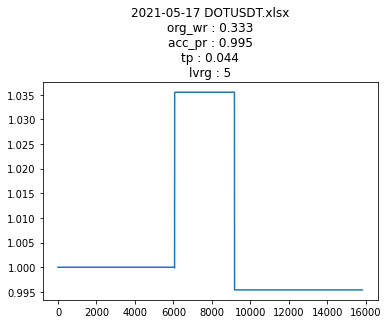

In [3]:
from tqdm.notebook import tqdm
from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

tp_list = np.arange(0.0, 0.05, 0.001)
lvrg_list = range(1, 10)
lvrg_list = range(3, 7)
lvrg_list = range(6, 10)
lvrg_list = range(1, 2)
lvrg_list = range(5, 6)

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  if 'dot'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))

    #     find best lvrg with lq    #
    for lvrg in lvrg_list:
      
      #       tp opt      #
      best_tp = None
      best_ap = 0
      best_pr = None

      #        find best tp       #
      for tp in tp_list:

        long_ep = ohlcv['close'].shift(1) * (1 / (tp + 1))

        #       long      #
        pr = (ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
        #     set condition   #
        pr = np.where(ohlcv['low'] < long_ep, pr, 1)
      
        lq = (ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

        # plt.plot(np.cumprod(pr))
        # plt.show()
        # break

        #       short       #
        # s_pr = (-ohlcv['close'].pct_change() - fee) * lvrg + 1

        #       fill na with 1.0      #
        pr = np.where(np.isnan(pr), 1, pr)
        # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
        lq = np.where(np.isnan(lq), 1, lq)
        # s_pr = np.where(np.isnan(s_pr), 1, pr)

        #       set lq      #
        pr = np.where((pr != 1) & (lq <= 0), 0, pr)
        # avoid_pr = np.where((avoid_pr != 1) & (lq <= 0), 0, avoid_pr)

        # plt.plot(np.cumprod(pr))
        # plt.title("%.3f" % tp)
        # plt.show()
        # plt.close()

        ap = np.cumprod(pr)[-1]
        if ap >= best_ap:
          best_ep = long_ep
          best_ap = ap
          best_tp = tp
          best_pr = pr

      best_pr = np.array(best_pr)
      org_wr = len(best_pr[best_pr > 1]) / len(best_pr[best_pr != 1])

      # plt.figure(figsize=(10, 4))
      plt.figure(figsize=(6, 4))
      # plt.subplot(121)
      plt.plot(np.cumprod(best_pr))
      plt.title("%s\norg_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr)[-1], best_tp, lvrg))

      
      #     avoid dropping    #      
      # ema = ohlcv['close'].ewm(span=190, min_periods=190-1, adjust=False).mean()
      # # avoid_pr = np.where(ohlcv['close'].shift(1) > ema.shift(1), test_pr, 1)

      # avoid_pr = np.where(ema.shift(1) > ema.shift(2), best_pr, 1)

      # # ma = ohlcv['close'].rolling(120).mean()
      # # avoid_pr = np.where(ma.shift(1) > ma.shift(2), best_pr, 1)

      # avoid_wr = len(avoid_pr[avoid_pr > 1]) / len(avoid_pr[avoid_pr != 1])

      
      # plt.subplot(122)
      # plt.plot(np.cumprod(avoid_pr))
      # plt.title("%s\navoid_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, avoid_wr, np.cumprod(avoid_pr)[-1], best_tp, lvrg))

      plt.show()








### setup

In [4]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### check data

In [5]:
df = ohlcv
print(df.head())

# sar = lucid_sar(ohlcv)
# ha_ohlc = heikinashi(ohlcv).iloc[:, :4]
# ema1, ema2, ema3 = ema_ribbon(ohlcv)
# senkou1, senkou2 = ichimoku(ohlcv)
# cbo, ema_cbo = cct_bbo(ohlcv, 21, 13) 

# _, _, bbw = bb_width(ohlcv, 20, 2) 

df['fish60'] = fisher(ohlcv, 60)
df['trix'] = trix_hist(ohlcv, 14, 1, 5) 
# rsi_ = rsi(ohlcv)
df['macd_hist'] = macd(ohlcv)

df.describe().transpose()

                           open    high     low   close   volume
2021-05-07 00:00:59.999  40.801  40.881  40.769  40.862  11567.2
2021-05-07 00:01:59.999  40.862  40.921  40.573  40.644  67078.2
2021-05-07 00:02:59.999  40.641  40.680  40.498  40.500  37598.6
2021-05-07 00:03:59.999  40.523  40.560  40.462  40.477  16816.8
2021-05-07 00:04:59.999  40.473  40.605  40.427  40.511  31256.4


,count,mean,std,min,25%,50%,75%,max
open,15840.0,40.822113,2.827351,32.432000,39.356000,40.167000,41.580000,49.766000
high,15840.0,40.893931,2.835840,32.801000,39.410750,40.228000,41.662500,49.855000
low,15840.0,40.749432,2.819406,32.000000,39.300000,40.106000,41.506500,49.644000
close,15840.0,40.821896,2.827420,32.421000,39.357000,40.165500,41.580250,49.765000
volume,15840.0,19079.415593,24425.041499,444.200000,6430.150000,11510.600000,21782.575000,448892.500000
fish60,15781.0,0.135282,2.210354,-7.589308,-1.349973,0.074315,1.536080,7.600397
trix,15835.0,0.000012,0.007698,-0.084258,-0.003635,-0.000092,0.003578,0.066075
macd_hist,15816.0,0.000012,0.039855,-0.425686,-0.019201,-0.000613,0.018773,0.284256


### remove nan data

In [6]:
print((np.isnan(df.values)))
print(np.sum(np.isnan(df.values), axis=0))

max_nan = np.max(np.sum(np.isnan(df.values), axis=0))
print(max_nan)

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[ 0  0  0  0  0 59  5 24]
59


In [7]:
df = df.iloc[max_nan:]

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,15781.0,40.823228,2.832533,32.432000,39.350000,40.162000,41.588000,49.766000
high,15781.0,40.895129,2.841033,32.801000,39.406000,40.223000,41.668000,49.855000
low,15781.0,40.750509,2.824574,32.000000,39.298000,40.103000,41.516000,49.644000
close,15781.0,40.823060,2.832595,32.421000,39.350000,40.161000,41.588000,49.765000
volume,15781.0,19079.274324,24438.303627,444.200000,6421.500000,11511.000000,21785.500000,448892.500000
fish60,15781.0,0.135282,2.210354,-7.589308,-1.349973,0.074315,1.536080,7.600397
trix,15781.0,0.000010,0.007700,-0.084258,-0.003630,-0.000092,0.003567,0.066075
macd_hist,15781.0,0.000049,0.039878,-0.425686,-0.019163,-0.000575,0.018814,0.284256


### macd gaussian survey

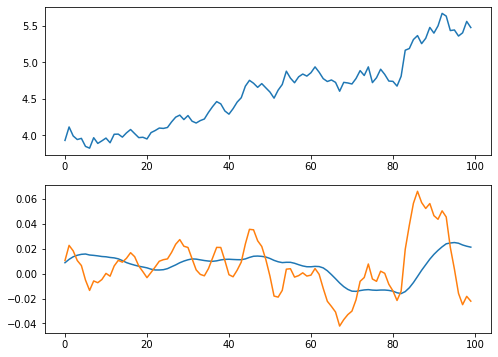

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d


g_curve = [np.nan] * len(df)
period = 20
sigma = 20

for i in range(period, len(df)):

  macd_hist = df['macd_hist'].values[i + 1 - period:i + 1]
  macd_hist_g = gaussian_filter1d(macd_hist, sigma=sigma, mode='reflect')
  g_curve[i] = macd_hist_g[-1] 

plot_size = 100

plt.subplot(211)
plt.plot(df['close'].values[period:][:plot_size])

plt.subplot(212) 
plt.plot(g_curve[period:][:plot_size])
plt.plot(df['macd_hist'].values[period:][:plot_size])

plt.show()

#### pr survey on gaussina macd

12777
12777
12777


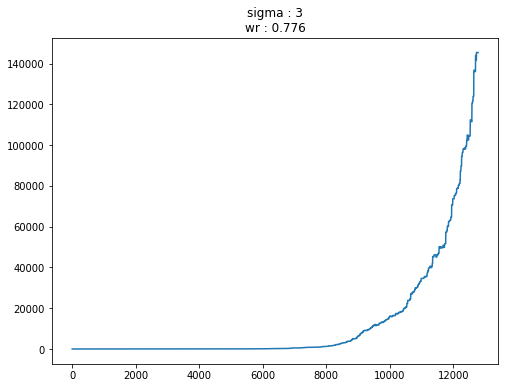

In [ ]:

g_curve = [np.nan] * len(df)
period = 20
sigma = 20

# for sigma in range(10, 50, 2):
# for sigma in range(1, 10, 1):
for sigma in range(3, 4, 1):

  #     realtime gaussian   #
  # for i in range(period, len(df)):

  #   macd_hist = df['macd_hist'].values[i + 1 - period:i + 1]
  #   macd_hist_g = gaussian_filter1d(macd_hist, sigma=sigma, mode='reflect')
  #   g_curve[i] = macd_hist_g[-1] 

  #     non realtime    #
  macd_hist = df['macd_hist'].values
  macd_hist_g = gaussian_filter1d(macd_hist, sigma=sigma, mode='reflect')
  g_curve = macd_hist_g

  g_curve_series = pd.Series(g_curve[period:])
  # print(g_curve_series.head())
  # break

  short_sig = np.where((g_curve_series.shift(1) < g_curve_series.shift(2)) &
                      (g_curve_series.shift(2) > g_curve_series.shift(3)), 1, 0)

  long_sig = np.where((g_curve_series.shift(1) > g_curve_series.shift(2)) &
                      (g_curve_series.shift(2) < g_curve_series.shift(3)), 1, 0)
  # print(short_sig)
  # break


  # print(np.argwhere(short_sig == 1).reshape(-1, ))
  # break

  short_sig_arg = np.argwhere(short_sig == 1).reshape(-1, )
  long_sig_arg = np.argwhere(long_sig == 1).reshape(-1, )
  print(len(long_sig))
  print(len(short_sig))

  close = df['close'].values[period:]
  print(len(close))
  # break

  #       1. check long version first    #
  #       2. entry long signal on close    #
  lvrg = 1
  fee = 0.0006
  pr_list = []

  for i in range(len(long_sig)):
    
    if long_sig[i]:

      ep = close[i]

      for j in range(i + 1, len(long_sig)):

        if short_sig[j]:

          pr = (close[j] / ep - 1 - fee) * lvrg + 1
          # print(pr)
          break

    else:

      pr = 1

    pr_list.append(pr)

  pr_list = np.array(pr_list)
  wr = len(pr_list[pr_list > 1]) / len(pr_list[pr_list != 1])

  plt.plot(np.cumprod(pr_list))
  plt.title("sigma : %s\nwr : %.3f" % (sigma, wr))
  plt.show()



  


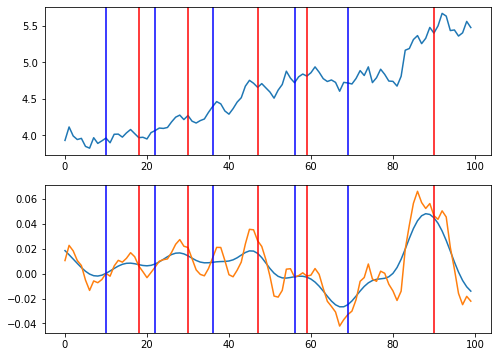

In [ ]:
g_curve_series = pd.Series(g_curve[period:])
# print(g_curve_series.head())
# break

short_sig = np.where((g_curve_series.shift(1) < g_curve_series.shift(2)) &
                    (g_curve_series.shift(2) > g_curve_series.shift(3)), 1, 0)

long_sig = np.where((g_curve_series.shift(1) > g_curve_series.shift(2)) &
                    (g_curve_series.shift(2) < g_curve_series.shift(3)), 1, 0)
# print(short_sig)
# break


# print(np.argwhere(short_sig == 1).reshape(-1, ))
# break

short_sig_arg = np.argwhere(short_sig == 1).reshape(-1, )
long_sig_arg = np.argwhere(long_sig == 1).reshape(-1, )

plot_size = 100

plt.subplot(211)
plt.plot(df['close'].values[period:][:plot_size])

for x_i in long_sig_arg:
  
  if x_i > plot_size:
    break

  plt.axvline(x_i, color='b')

for x_i in short_sig_arg:
  
  if x_i > plot_size:
    break

  plt.axvline(x_i, color='r')

plt.subplot(212) 
plt.plot(g_curve[period:][:plot_size])
plt.plot(df['macd_hist'].values[period:][:plot_size])

for x_i in long_sig_arg:
  
  if x_i > plot_size:
    break

  plt.axvline(x_i, color='b')

for x_i in short_sig_arg:
  
  if x_i > plot_size:
    break

  plt.axvline(x_i, color='r')


plt.show()

### time survey

                           open    high     low   close   volume    fish60      trix  macd_hist   Day sin   Day cos  Year sin  Year cos
2021-05-07 00:59:59.999  40.097  40.139  40.034  40.070  33343.4 -0.162763 -0.004065   0.011602  0.258819  0.965926  0.820591 -0.571515
2021-05-07 01:00:59.999  40.064  40.271  40.061  40.170  48229.7 -0.297724 -0.001362   0.027238  0.263031  0.964787  0.820585 -0.571525
2021-05-07 01:01:59.999  40.170  40.337  40.134  40.328  35987.0 -0.352310  0.001831   0.049001  0.267238  0.963630  0.820578 -0.571535
2021-05-07 01:02:59.999  40.328  40.371  40.270  40.321  16678.5 -0.311950  0.004824   0.059330  0.271440  0.962455  0.820571 -0.571545
2021-05-07 01:03:59.999  40.327  40.432  40.313  40.422  12396.6 -0.211822  0.007742   0.070732  0.275637  0.961262  0.820564 -0.571554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Text(0.5, 1.0, 'Time of day signal')

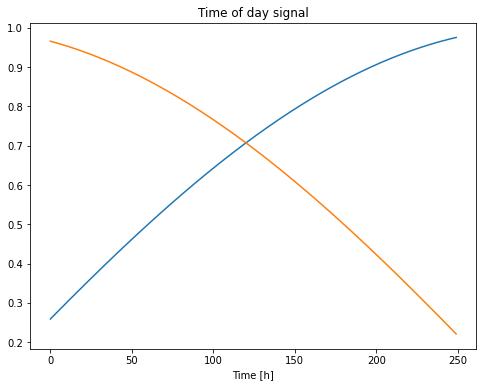

In [8]:
timestamp_s = df.index.map(datetime.datetime.timestamp)

# print(timestamp_s)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

print(df.head())

plt.plot(np.array(df['Day sin'])[:250])
plt.plot(np.array(df['Day cos'])[:250])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

### target column

In [9]:
target = "close"
target = "macd_hist"
# target = 'T (degC)'

#### fft

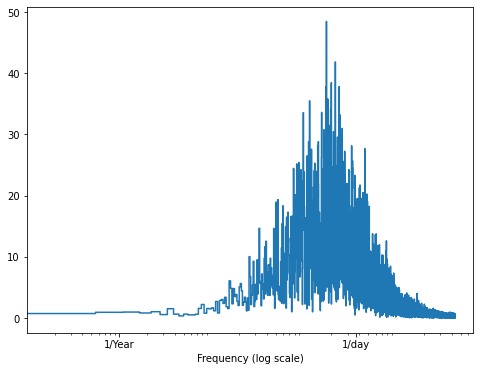

In [10]:
fft = tf.signal.rfft(df[target])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df[target])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
# plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### data proc

In [26]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print("num_features :", num_features)
print("column_indices :", column_indices)

num_features : 12
column_indices : {'open': 0, 'high': 1, 'low': 2, 'close': 3, 'volume': 4, 'fish60': 5, 'trix': 6, 'macd_hist': 7, 'Day sin': 8, 'Day cos': 9, 'Year sin': 10, 'Year cos': 11}


### scaling

In [27]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

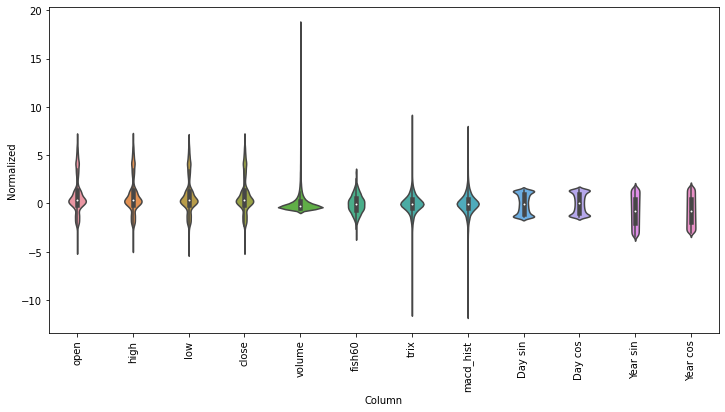

In [28]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### windowing

In [53]:
data_x, data_labels = [], []
data_index = []

input_size = 12
label_size = 12
total_window_size = input_size + label_size

n = len(df)
train_df = df[input_size:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):-label_size]

test_df_copy = test_df.copy()

train_mean = train_df.mean()
train_std = train_df.std()
df_std = (df - train_mean) / train_std

column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = df.shape[1]
print("num_features :", num_features)
print("column_indices :", column_indices)

for i in range(input_size, len(df_std) - label_size):
    
    temp_data = df_std.values[i - input_size:i]
    temp_labels = df_std.values[i:i + label_size]

    # print(df.index[i - input_size:i][-1])
    # print(df.index[i:i + label_size][0])
    # print()

    if np.isnan(np.sum(temp_data)):
      continue

    data_x.append(temp_data)
    data_labels.append(temp_labels)


data_x = np.array(data_x).astype(np.float32)

#         feature selection       #
close_x = data_x[-len(test_df):, :, [3]]
data_x = data_x[:, :, [7]]

data_labels = np.array(data_labels).astype(np.float32)

print(len(df) - total_window_size)
print("data_x.shape :", data_x.shape)
print("data_labels.shape :", data_labels.shape)

print("data_x.dtype :", data_x.dtype)
print("data_labels.dtype :", data_labels.dtype)

train_x = data_x[:len(train_df)]
val_x = data_x[len(train_df):len(train_df) + len(val_df)]
test_x = data_x[-len(test_df):]

print("len(train_x) :", len(train_x))
print("len(val_x) :", len(val_x))
print("len(test_x) :", len(test_x))

train_labels = data_labels[:len(train_df)]
val_labels = data_labels[len(train_df):len(train_df) + len(val_df)]
test_labels = data_labels[-len(test_df):]


num_features : 12
column_indices : {'open': 0, 'high': 1, 'low': 2, 'close': 3, 'volume': 4, 'fish60': 5, 'trix': 6, 'macd_hist': 7, 'Day sin': 8, 'Day cos': 9, 'Year sin': 10, 'Year cos': 11}
15757
data_x.shape : (15757, 12, 1)
data_labels.shape : (15757, 12, 12)
data_x.dtype : float32
data_labels.dtype : float32
len(train_x) : 11034
len(val_x) : 3156
len(test_x) : 1567


#### select target label

train_labels.shape : (11034, 12, 12)
train_y.shape : (11034, 12, 1)


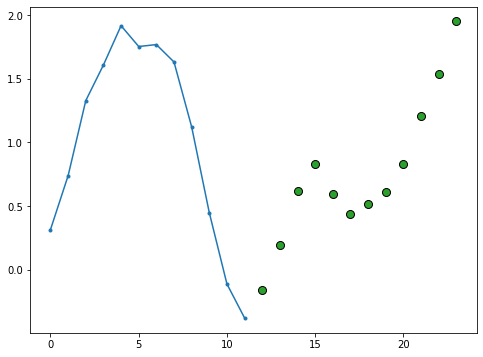

In [54]:
target_label = 'macd_hist'
target_label = target
target_label_index = column_indices[target_label]

train_y = train_labels[:, :, [target_label_index]]
val_y = val_labels[:, :, [target_label_index]]
test_y = test_labels[:, :, [target_label_index]]

print("train_labels.shape :", train_labels.shape)
print("train_y.shape :", train_y.shape)

try:
  input = train_x[0, :, target_label_index]
except:
  input = train_x[0, :, 0]  

label = train_y[0]

plt.plot(np.arange(len(input)), input,
          label='Inputs', marker='.', zorder=-10)    
plt.scatter(np.arange(len(label)) + input_size, label,
          edgecolors='k', label='Labels', c='#2ca02c', s=64)

plt.show()

### multi step

### models

In [58]:
MAX_EPOCHS = 100
# MAX_EPOCHS = 50

patience = MAX_EPOCHS // 5
# patience = 2

ckpt_path = current_path + 'ckpt/'

def compile_and_fit(model, model_name, patience=patience):

  checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=1e-3, decay=1e-5),
                # optimizer=tf.optimizers.Adam(learning_rate=1e-4, decay=1e-5),
                metrics=[tf.metrics.MeanAbsoluteError()])
  

  history = model.fit(train_x, train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                      callbacks=[checkpoint, early_stopping],
                      batch_size=32)
  return history

In [20]:
multi_val_performance = {}
multi_performance = {}

#### dense

In [ ]:
OUT_STEPS = label_size

multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

model_name = 'multi_step_macdhist_dense_%s_%s.h5' % (input_size, label_size)
# model_name = 'multi_step_weather_dense_%s_%s.h5' % (input_size, label_size)

In [ ]:
history = compile_and_fit(multi_dense_model, model_name)

In [ ]:
model = tf.keras.models.load_model(ckpt_path + model_name)

multi_val_performance['Dense'] = model.evaluate(val_x, val_y)
multi_performance['Dense'] = model.evaluate(test_x, test_y, verbose=1)

49/49 [==============================] - 0s 2ms/step - loss: 1.5460 - mean_absolute_error: 0.9291


##### denorm

In [ ]:
test_result = model.predict(test_x)

In [ ]:
# print(len(test_result))
# print(test_result.shape)
# print(len(test_y))
# break

pred_y = test_result[:, :, target_label_index]

for i in range(len(test_y)):

  label = test_y[i]
  pred = pred_y[i]

  print("label.shape :", label.shape)
  print("pred.shape :", pred.shape)

  plt.scatter(np.arange(len(pred)), label,
            edgecolors='k', label='Labels', c='#2ca02c', s=64)
  plt.scatter(np.arange(len(pred)), pred,
              marker='X', edgecolors='k', label='Predictions',
              c='#ff7f0e', s=64)
  
  plt.show()
  plt.close()

Output hidden; open in https://colab.research.google.com to view.

##### check profit

In [ ]:
test_result = model.predict(test_x)

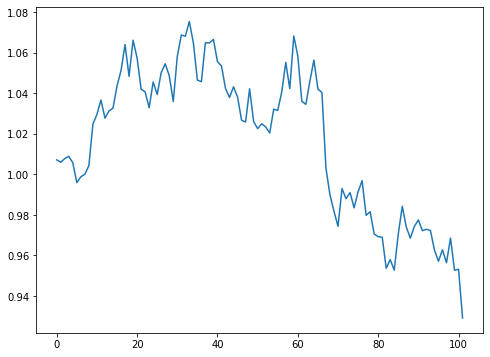

In [ ]:
pred_y = test_result[:, :, target_label_index]

fee = 0.0006
lvrg = 1
pr_list = []
# plotting = True
plotting = False

i = 0
while 1:
# for i in range(len(test_y)):

  input = test_x[i, :, target_label_index]

  label = test_y[i]
  pred = pred_y[i]

  input_close = test_x[i, :, 3] * train_std['close'] + train_mean['close']
  close = test_labels[i, :, 3] * train_std['close'] + train_mean['close']

  #     find highest / lowest arg     #
  high_arg = np.argmax(pred)
  low_arg = np.argmin(pred)

  #     we always sell high, buy low    #
  pr = (close[high_arg] / close[low_arg] - 1 - fee) * lvrg + 1

  if plotting:

    plt.subplot(211)
    plt.plot(np.arange(len(input_close)), input_close)
    plt.plot(np.arange(len(close)) + input_size, close)
    plt.axvline(high_arg + input_size)
    plt.axvline(low_arg + input_size)

    plt.subplot(212)
    plt.plot(np.arange(len(input)), input,
             label='Inputs', marker='.', zorder=-10)    
    plt.scatter(np.arange(len(label)) + input_size, label,
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
    plt.scatter(np.arange(len(pred)) + input_size, pred,
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
    # plt.plot(pred)
    # plt.plot(label)
    plt.axvline(high_arg + input_size)
    plt.axvline(low_arg + input_size)


    plt.suptitle("%.3f" % pr)
    plt.show()

  pr_list.append(pr)

  #     i should moved to end of trading index    #
  #     long    #
  if high_arg > low_arg:
    i += high_arg
  else:
    i += low_arg

  # print("i :", i)

  if i >= len(test_y):
    break
  # else:
  #   pr = (close[low_arg] / close[high_arg] - 1 - fee) * lvrg + 1

  #     shift, if trade complished    #

plt.plot(np.cumprod(pr_list))
plt.show()


#### lstm

In [ ]:
OUT_STEPS = label_size

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

model_name = 'multi_step_macdhist_lstm_%s_%s.h5' % (input_size, label_size)


In [ ]:
history = compile_and_fit(multi_dense_model, model_name)

# IPython.display.clear_output()

In [ ]:
model = tf.keras.models.load_model(ckpt_path + model_name)

multi_val_performance['Dense'] = model.evaluate(val_x, val_y)
multi_performance['Dense'] = model.evaluate(test_x, test_y, verbose=1)

49/49 [==============================] - 0s 2ms/step - loss: 1.8453 - mean_absolute_error: 1.0258


##### check profit

In [ ]:
test_result = model.predict(test_x)

In [ ]:
pred_y = test_result[:, :, target_label_index]

fee = 0.0006
lvrg = 5
pr_list = []
plotting = True
# plotting = False

i = 0
while 1:
# for i in range(len(test_y)):

  input = test_x[i, :, target_label_index]

  label = test_y[i]
  pred = pred_y[i]

  input_close = test_x[i, :, 3] * train_std['close'] + train_mean['close']
  close = test_labels[i, :, 3] * train_std['close'] + train_mean['close']

  #     find highest / lowest arg     #
  high_arg = np.argmax(pred)
  low_arg = np.argmin(pred)

  #     we always sell high, buy low    #
  pr = (close[high_arg] / close[low_arg] - 1 - fee) * lvrg + 1

  if plotting:

    plt.subplot(211)
    plt.plot(np.arange(len(input_close)), input_close)
    plt.plot(np.arange(len(close)) + input_size, close)
    plt.axvline(high_arg + input_size)
    plt.axvline(low_arg + input_size)

    plt.subplot(212)
    plt.plot(np.arange(len(input)), input,
             label='Inputs', marker='.', zorder=-10)    
    plt.scatter(np.arange(len(label)) + input_size, label,
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
    plt.scatter(np.arange(len(pred)) + input_size, pred,
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
    # plt.plot(pred)
    # plt.plot(label)
    plt.axvline(high_arg + input_size)
    plt.axvline(low_arg + input_size)


    plt.suptitle("%.3f" % pr)
    plt.show()

  pr_list.append(pr)

  #     i should moved to end of trading index    #
  #     long    #
  if high_arg > low_arg:
    i += high_arg
  else:
    i += low_arg

  # print("i :", i)

  if i >= len(test_y):
    break
  # else:
  #   pr = (close[low_arg] / close[high_arg] - 1 - fee) * lvrg + 1

  #     shift, if trade complished    #

plt.plot(np.cumprod(pr_list))
plt.show()


Output hidden; open in https://colab.research.google.com to view.

#### cnn

In [56]:
CONV_WIDTH = 3
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(label_size*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, label_size, features]
    tf.keras.layers.Reshape([label_size, num_features])
])

model_name = 'multi_step_macdhist_cnn_macdhist_%s_%s.h5' % (input_size, label_size)

In [59]:
history = compile_and_fit(multi_conv_model, model_name)


IPython.display.clear_output()

In [60]:
model = tf.keras.models.load_model(ckpt_path + model_name)

multi_val_performance['Dense'] = model.evaluate(val_x, val_y)
multi_performance['Dense'] = model.evaluate(test_x, test_y, verbose=1)

49/49 [==============================] - 0s 1ms/step - loss: 1.1118 - mean_absolute_error: 0.7561


##### denorm

In [ ]:
label_col_index = column_indices[target]

for images, labels in multi_window.test.take(100000):  # only take first element of dataset
    x = images.numpy()
    y = labels.numpy()

    print("y.shape :", y.shape)
    print("multi_lstm_model(x).shape :", multi_lstm_model(x).shape)

    for n in range(len(x)):
      label = y[n, :, 0]
      pred = multi_lstm_model(x)[n, :, label_col_index]

      print("label.shape :", label.shape)
      print("pred.shape :", pred.shape)

      plt.scatter(np.arange(len(pred)), label,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
      plt.scatter(np.arange(len(pred)), pred,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      
      plt.show()
      plt.close()

##### check profit

In [61]:
test_result = model.predict(test_x)

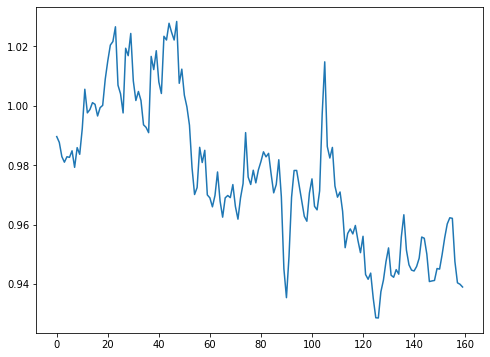

In [64]:
pred_y = test_result[:, :, target_label_index]

fee = 0.0006
lvrg = 5
lvrg = 1
pr_list = []
# plotting = True
plotting = False

i = 0
while 1:
# for i in range(len(test_y)):

  try:
    input = test_x[i, :, target_label_index]
  except:
    input = test_x[i, :, 0]


  label = test_y[i]
  pred = pred_y[i]

  input_close = close_x[i, :, :] * train_std['close'] + train_mean['close']
  # input_close = test_x[i, :, 3] * train_std['close'] + train_mean['close']
  close = test_labels[i, :, 3] * train_std['close'] + train_mean['close']

  #     find highest / lowest arg     #
  high_arg = np.argmax(pred)
  low_arg = np.argmin(pred)

  #     we always sell high, buy low    #
  pr = (close[high_arg] / close[low_arg] - 1 - fee) * lvrg + 1

  if plotting:

    plt.subplot(211)
    plt.plot(np.arange(len(input_close)), input_close)
    plt.plot(np.arange(len(close)) + input_size, close)
    plt.axvline(high_arg + input_size)
    plt.axvline(low_arg + input_size)

    plt.subplot(212)
    plt.plot(np.arange(len(input)), input,
             label='Inputs', marker='.', zorder=-10)    
    plt.scatter(np.arange(len(label)) + input_size, label,
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
    plt.scatter(np.arange(len(pred)) + input_size, pred,
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
    # plt.plot(pred)
    # plt.plot(label)
    plt.axvline(high_arg + input_size)
    plt.axvline(low_arg + input_size)


    plt.suptitle("%.3f" % pr)
    plt.show()

  pr_list.append(pr)

  #     i should moved to end of trading index    #
  #     long    #
  if high_arg > low_arg:
    i += high_arg
  else:
    i += low_arg

  # print("i :", i)

  if i >= len(test_y):
    break
  # else:
  #   pr = (close[low_arg] / close[high_arg] - 1 - fee) * lvrg + 1

  #     shift, if trade complished    #

plt.plot(np.cumprod(pr_list))
plt.show()


#### autoregressive

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 12])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 60, 12)


77/77 [==============================] - 1s 13ms/step - loss: 8.8601 - mean_absolute_error: 2.2732


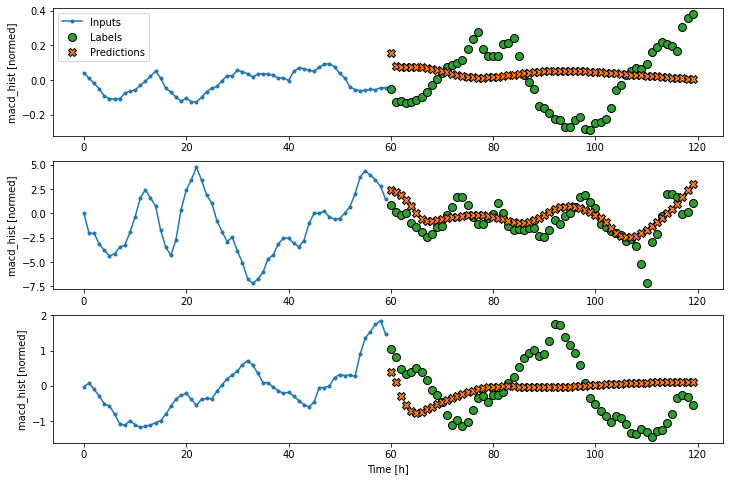

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

##### denorm

y.shape : (32, 60, 1)
multi_lstm_model(x).shape : (32, 60, 12)
label.shape : (60,)
pred.shape : (60,)


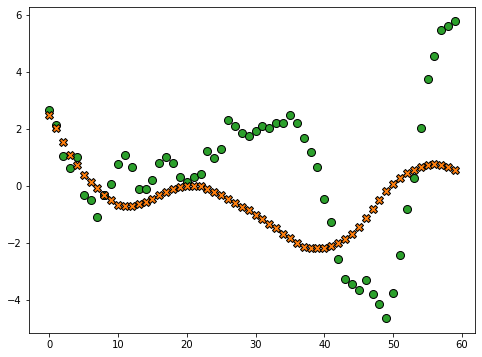

label.shape : (60,)
pred.shape : (60,)


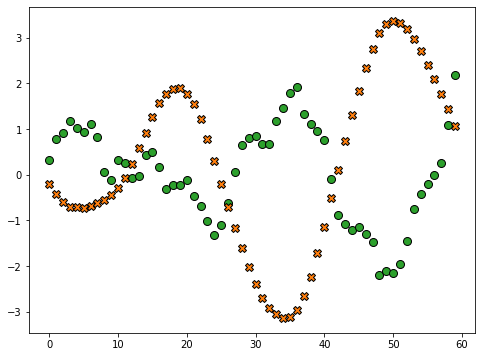

label.shape : (60,)
pred.shape : (60,)


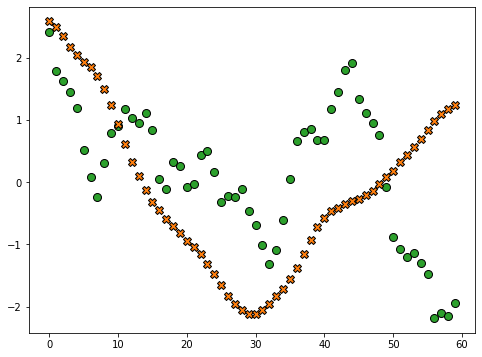

label.shape : (60,)
pred.shape : (60,)


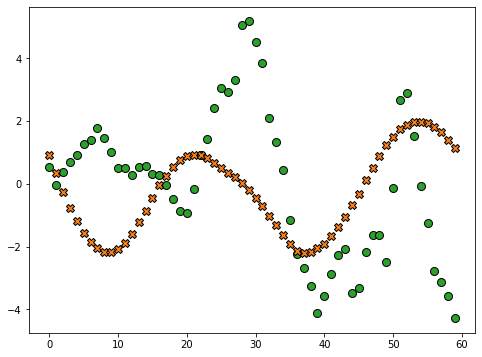

label.shape : (60,)
pred.shape : (60,)


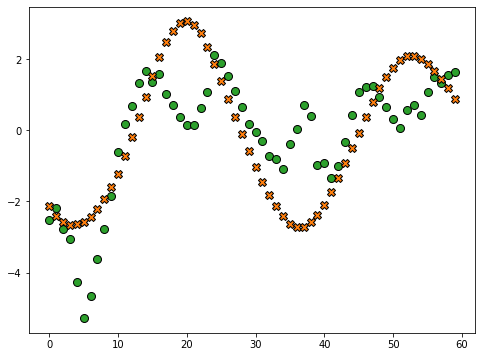

label.shape : (60,)
pred.shape : (60,)


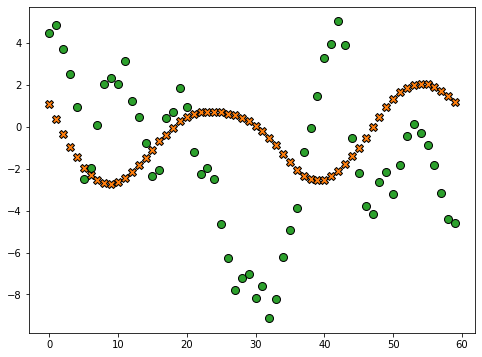

label.shape : (60,)
pred.shape : (60,)


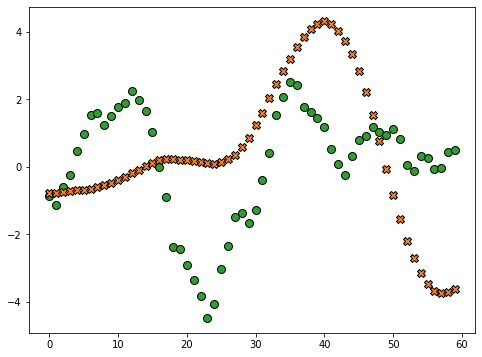

label.shape : (60,)
pred.shape : (60,)


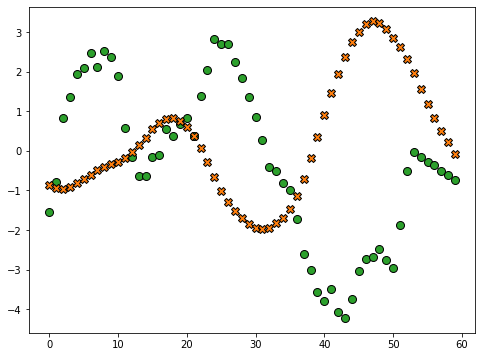

label.shape : (60,)
pred.shape : (60,)


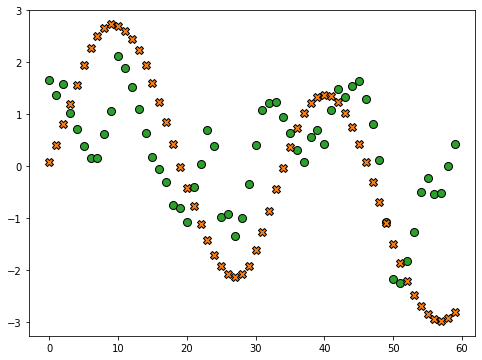

label.shape : (60,)
pred.shape : (60,)


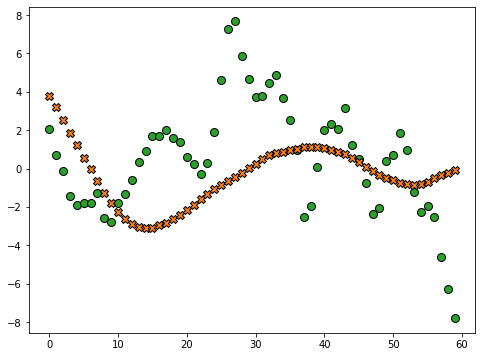

label.shape : (60,)
pred.shape : (60,)


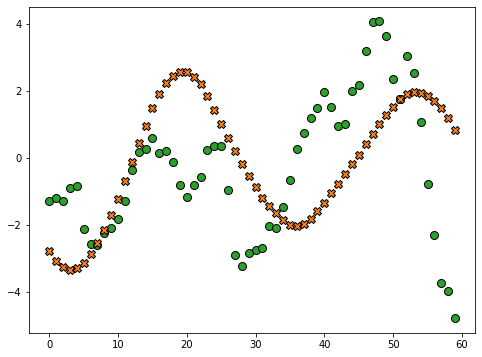

label.shape : (60,)
pred.shape : (60,)


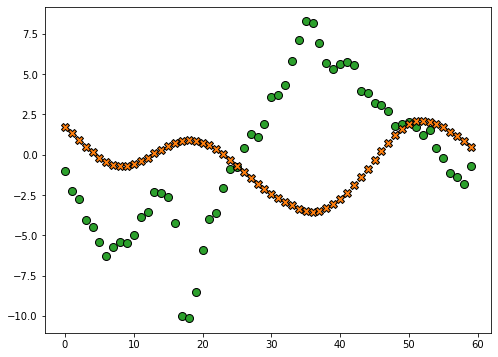

label.shape : (60,)
pred.shape : (60,)


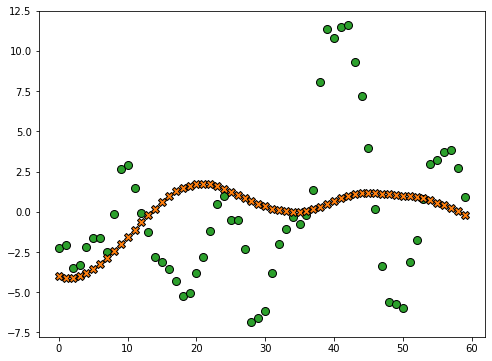

label.shape : (60,)
pred.shape : (60,)


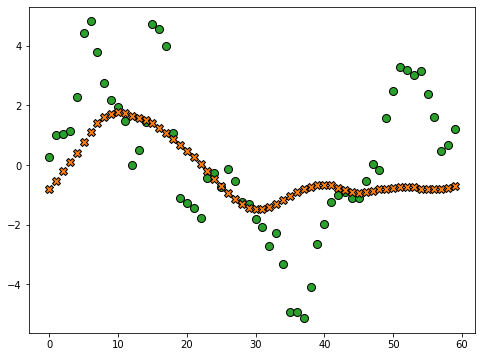

label.shape : (60,)
pred.shape : (60,)


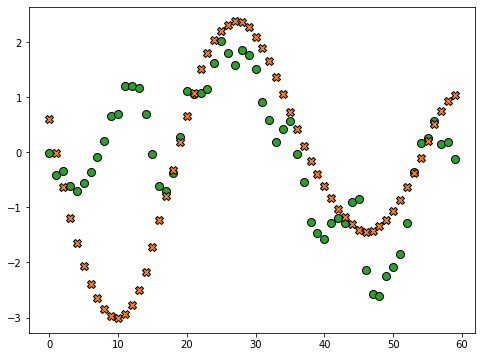

label.shape : (60,)
pred.shape : (60,)


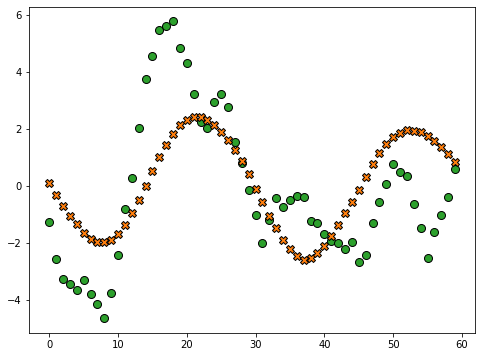

label.shape : (60,)
pred.shape : (60,)


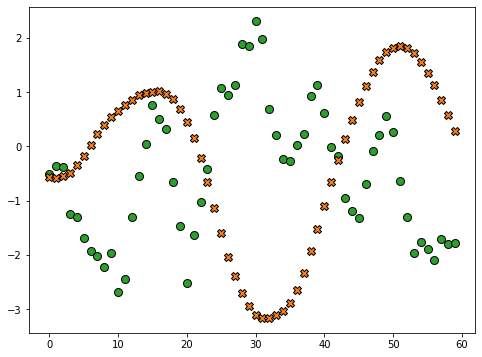

label.shape : (60,)
pred.shape : (60,)


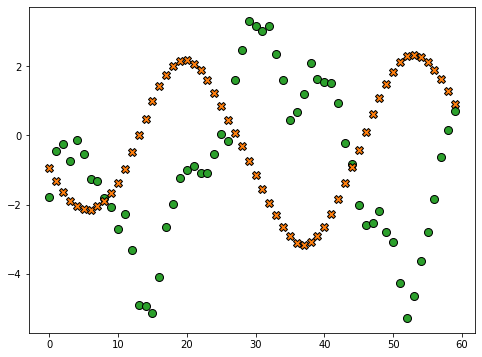

label.shape : (60,)
pred.shape : (60,)


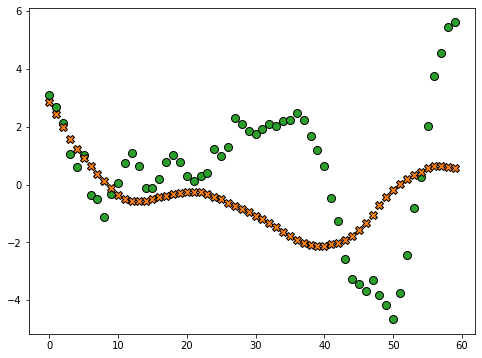

label.shape : (60,)
pred.shape : (60,)


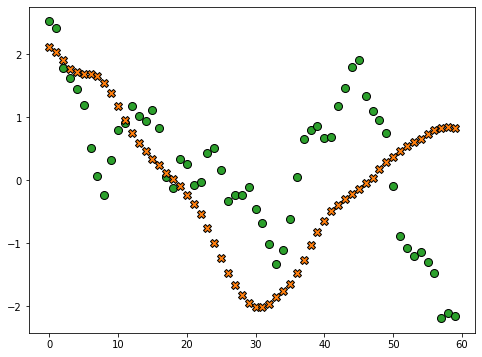

label.shape : (60,)
pred.shape : (60,)


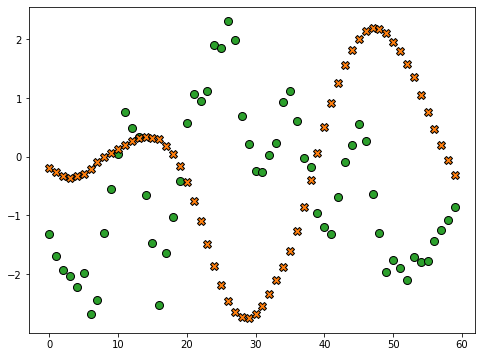

label.shape : (60,)
pred.shape : (60,)


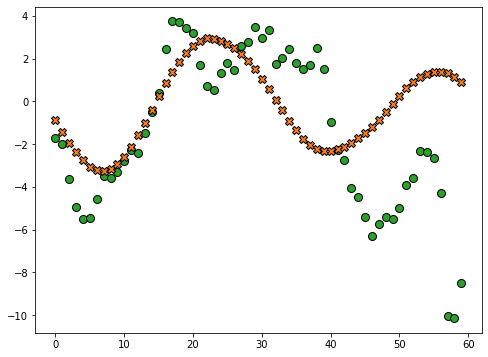

label.shape : (60,)
pred.shape : (60,)


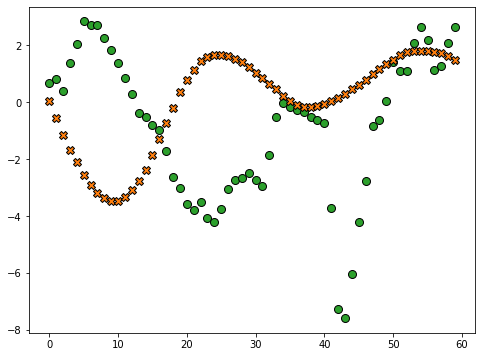

label.shape : (60,)
pred.shape : (60,)


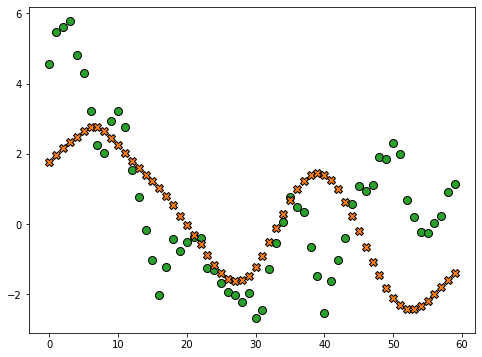

label.shape : (60,)
pred.shape : (60,)


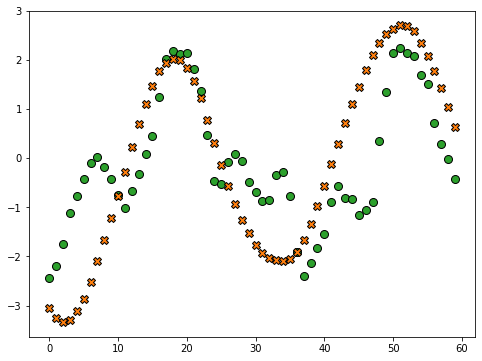

label.shape : (60,)
pred.shape : (60,)


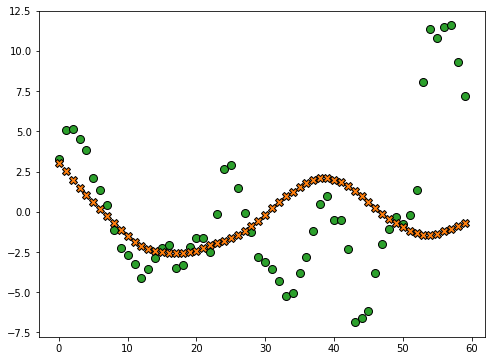

label.shape : (60,)
pred.shape : (60,)


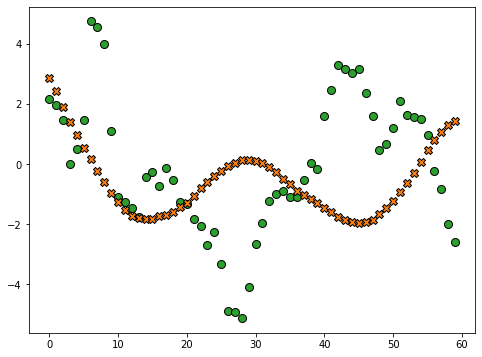

label.shape : (60,)
pred.shape : (60,)


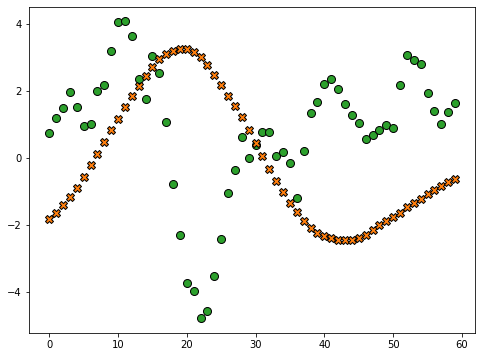

label.shape : (60,)
pred.shape : (60,)


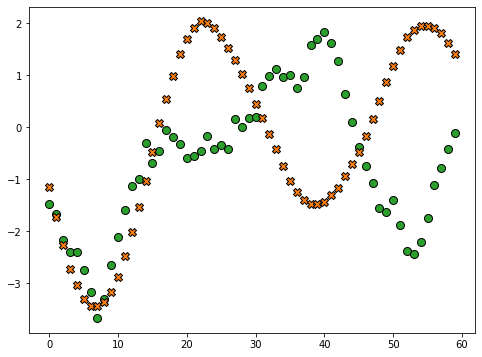

label.shape : (60,)
pred.shape : (60,)


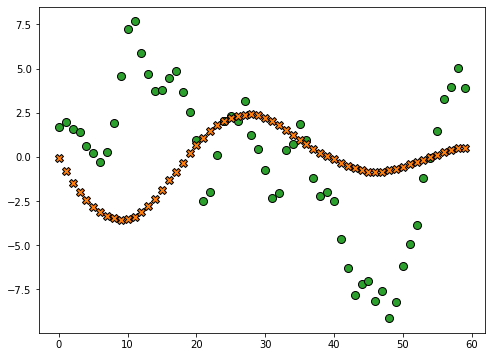

label.shape : (60,)
pred.shape : (60,)


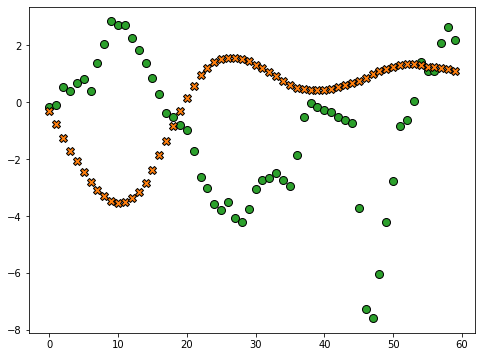

label.shape : (60,)
pred.shape : (60,)


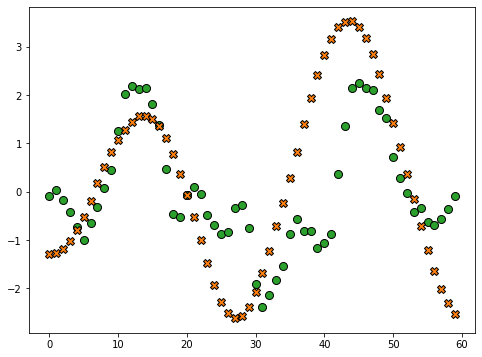

y.shape : (32, 60, 1)
multi_lstm_model(x).shape : (32, 60, 12)
label.shape : (60,)
pred.shape : (60,)


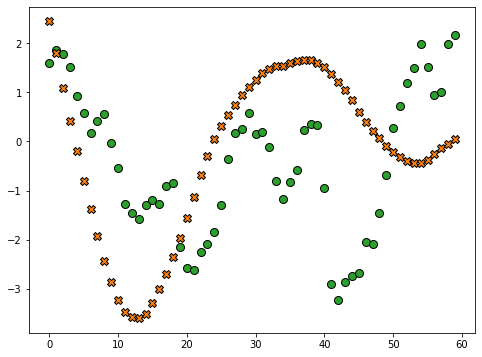

label.shape : (60,)
pred.shape : (60,)


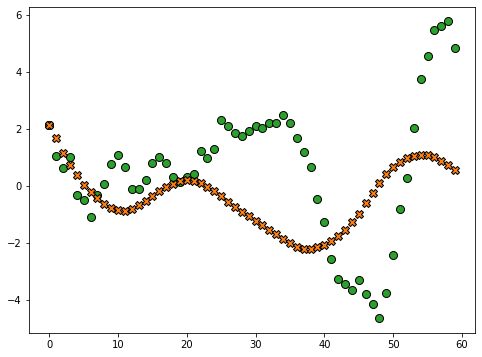

label.shape : (60,)
pred.shape : (60,)


KeyboardInterrupt: ignored

In [ ]:
label_col_index = column_indices[target]

for images, labels in multi_window.test.take(100000):  # only take first element of dataset
    x = images.numpy()
    y = labels.numpy()

    print("y.shape :", y.shape)
    print("multi_lstm_model(x).shape :", multi_lstm_model(x).shape)

    for n in range(len(x)):
      label = y[n, :, 0]
      pred = multi_lstm_model(x)[n, :, label_col_index]

      print("label.shape :", label.shape)
      print("pred.shape :", pred.shape)

      plt.scatter(np.arange(len(pred)), label,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
      plt.scatter(np.arange(len(pred)), pred,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      
      plt.show()
      plt.close()

#### comparison

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Dense   : 1.8391
LSTM    : 1.9033
Conv    : 1.8230
AR LSTM : 2.3262
